# Project Goal 

Automated Resume Writer powered by LangGraph.
This project demonstrates how to build an agentic workflow for automatic resume drafting and editing:

- Qualification Extraction Subgraph: Parses job postings, loops with human feedback until approved.

- Resume Drafting: Generates a tailored resume draft based on the user’s existing CV.

- Editor Feedback: Runs through multiple editors for critique and revision (supports up to 2 feedback loops).

- LangGraph Studio Integration: Enables human-in-the-loop interactions for a seamless editing experience.

- Traceable Workflows: Full execution documented in 5 publicly available LangSmith prompt traces.

# Setup

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

In [85]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [86]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

In [87]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

# Qualification Extraction Subgraph

- Parses job postings to extract required qualifications.

- Uses structured state management to capture extracted skills and requirements.

- Human-in-the-Loop Feedback:

    - Allows users to review extracted qualifications.

    - Users can flag or remove qualifications they don’t have.

    - Ensures the resume highlights only accurate and relevant qualifications.

- Outcome: Produces a tailored, truthful resume draft aligned with the target job posting.

In [88]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# ---- Structured output models ----
class Qualifications(BaseModel):
    required: List[str] = Field(
        description="List of required qualifications for the job."
    )
    preferred: List[str] = Field(
        description="List of preferred qualifications for the job."
    )

class JobQualsState(TypedDict):
    job_post: str   # Raw job posting text
    human_feedback: str   # Human feedback on missing qualifications
    qualifications: Qualifications # Extracted qualifications

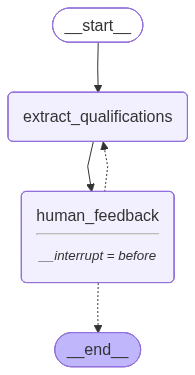

In [89]:
# ---- Node: Extract qualifications ----
def extract_qualifications(state: JobQualsState):
    job_post = state["job_post"]
    human_feedback = state.get("human_feedback", "")

    structured_llm = llm.with_structured_output(Qualifications)

    # ---- Instructions ----
    qualification_instructions = """You are tasked with analyzing a job posting and coming up with a outline for writing tailored resume.
    
    1. Carefully read the following job post:
    {job_post}
    
    2. Extract qualifications into two categories, focus on keywords of technology required, such as Power BI and AWS :
       - Required (must-have skills/credentials/experience)
       - Preferred (nice-to-have or optional)
    
    3. Update qualification with similar item based on human feedback of the user:
    {human_feedback}
    
    3. Return the structured lists.
    """

    system_message = qualification_instructions.format(
        job_post=job_post, 
        human_feedback = human_feedback
    )

    qualifications = structured_llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="Extract the qualifications now.")]
    )

    return {"qualifications": qualifications}

# ---- Node: Human feedback ----
def human_feedback_node(state: JobQualsState):
    """Interrupts the flow to allow a human to provide feedback."""
    pass

# ---- Graph construction ----
qua_builder = StateGraph(JobQualsState)
qua_builder.add_node("extract_qualifications", extract_qualifications)
qua_builder.add_node("human_feedback", human_feedback_node)

qua_builder.add_edge(START, "extract_qualifications")
qua_builder.add_edge("extract_qualifications", "human_feedback")
qua_builder.add_conditional_edges("human_feedback", should_continue, ["extract_qualifications", END])

memory = MemorySaver()
qua_graph = qua_builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# Optional visualization
from IPython.display import Image, display
display(Image(qua_graph.get_graph(xray=1).draw_mermaid_png()))

## Unit Test

In [47]:
# Sample Job Posting
job_post = """
What Will You Do?

Investigate business processes and design, maintain, and refine models of business workflow
Measure and forecast demand for several diverse business units
Calculate optimal staffing levels
Collect, manipulate, and analyze data related to capacity, supply, and demand
Maintain and measure resourcing forecast and capacity models
Work within a team to provide analysis, insights and recommendations to senior business leaders to help them recognize areas of opportunity and drive evidence-based operational decisions
Formally apply statistical / scientific rigour to analysis of data
Look for ways to innovate and improve processes in a Continuous Improvement environment

What you need to succeed?

One plus year of experience in data analysis with an emphasis on forecasting or predictive analysis
Experience on building models on multiple toolset – Python, AWS Sagemaker
Should able to visualize model outcomes with other data on visualization platform like Tableau, Power BI
Familiarity with querying data using SQL
Experience analyzing and modeling business process data
Strong critical thinking & creative problem solving
Demonstrated experience working with data, including transformation, manipulation, forecasting, and statistical modeling
Experience using a variety of data analysis methods and forecasting techniques including statistical and simulation-based approaches
Experience working with time series data, using a variety of forecasting methods
Experience measuring and interpreting forecast accuracy
Ability to assess model validity and appropriateness
Demonstrated ability to produce and communicate meaningful results from data
Ability to effectively visualize and present complex data adapted to a variety of audiences
Demonstrated ability to turn forecast volumes into capacity models
As this position is posted in several locations, we specify that bilingualism (French, English, both oral and written) is required for Quebec only for the frequent interactions with English and French-speaking colleagues or internal partners across Canada or worldwide.

Preferred skills:

Minimum of Bachelor degree in Statistics, Operations Research, Computer Science, Software Engineering, Mathematics, Econometrics, or equivalent experience

Assets

Experience with Workforce Management Software (IEX, Genesys)
Experience using large databases with complex relationships between tables
Experience working with Call Centre data, understanding of queuing theory and Call Centre mathematics

Unique Requirements

As a condition of the role, the successful candidate must obtain a Government of Canada Reliability Status security clearance through Sun Life in advance of the start date.
"""

# Thread config
thread = {"configurable": {"thread_id": "job1"}}

# Run the graph until the first interruption
for event in graph.stream({"job_post": job_post}, thread, stream_mode="values"):
    quals = event.get("qualifications", None)
    if quals:
        print("=== Extracted Qualifications ===")
        print("Required:")
        for q in quals.required:
            print(f" - {q}")
        print("Preferred:")
        for q in quals.preferred:
            print(f" - {q}")
        print("=" * 50)

# Get state and check the next node (should be waiting for human feedback)
state = graph.get_state(thread)
print("Next node:", state.next)


=== Extracted Qualifications ===
Required:
 - One plus year of experience in data analysis with an emphasis on forecasting or predictive analysis
 - Experience on building models on multiple toolset – Python, Vertex AI, AI suite in Azure
 - Ability to visualize model outcomes with other data on visualization platform like Tableau, Power BI
 - Familiarity with querying data using SQL
 - Experience analyzing and modeling business process data
 - Strong critical thinking & creative problem solving
 - Demonstrated experience working with data, including transformation, manipulation, forecasting, and statistical modeling
 - Experience using a variety of data analysis methods and forecasting techniques including statistical and simulation-based approaches
 - Experience working with time series data, using a variety of forecasting methods
 - Experience measuring and interpreting forecast accuracy
 - Ability to assess model validity and appropriateness
 - Demonstrated ability to produce and co

In [48]:
# Now simulate human feedback
graph.update_state(
    thread,
    {
        "human_feedback": """
            I don't have AWS Sagemaker but have Vertex AI and AI suite in Azure 
            and no Genesys and IEX experience 
            but have built ChatBot for customer interaction on Whatsapp and never worked with Call centre data, 
            plz modify requirement to match
        """
    },
    as_node="human_feedback"
)

# Rerun the graph to see updated qualifications
for event in graph.stream({}, thread, stream_mode="values"):
    quals = event.get("qualifications", None)
    if quals:
        print("=== Updated Qualifications with Feedback ===")
        print("Required:")
        for q in quals.required:
            print(f" - {q}")
        print("Preferred:")
        for q in quals.preferred:
            print(f" - {q}")
        print("=" * 50)

=== Updated Qualifications with Feedback ===
Required:
 - One plus year of experience in data analysis with an emphasis on forecasting or predictive analysis
 - Experience on building models on multiple toolset – Python, Vertex AI, AI suite in Azure
 - Ability to visualize model outcomes with other data on visualization platform like Tableau, Power BI
 - Familiarity with querying data using SQL
 - Experience analyzing and modeling business process data
 - Strong critical thinking & creative problem solving
 - Demonstrated experience working with data, including transformation, manipulation, forecasting, and statistical modeling
 - Experience using a variety of data analysis methods and forecasting techniques including statistical and simulation-based approaches
 - Experience working with time series data, using a variety of forecasting methods
 - Experience measuring and interpreting forecast accuracy
 - Ability to assess model validity and appropriateness
 - Demonstrated ability to pr

# Full Graph

- Overall Workflow: Automated resume writer built with LangGraph.
- **Step 1** – Qualification Extraction Subgraph
    - Extracts qualifications from a job posting.
    - Human-in-the-loop correction to remove irrelevant/untrue qualifications.
    - Loops until user approves the qualification list.
- **Step 2** – Resume Drafting
- **Step 3** – Editor Feedback
    - Editor A: Provides basic critique and suggestions.
    - Editor B: Intended to integrate with Jobgether & GPTZero APIs for advanced checks (temporarily omitted due to unstable API setup).
- **Step 4** – Iterative Editing
    - Loops editor feedback up to 2 rounds of revisions.
    - Finalizes and outputs the polished resume.

C:\Users\wongh\AppData\Local\Temp\ipykernel_21540\1143634284.py:7: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


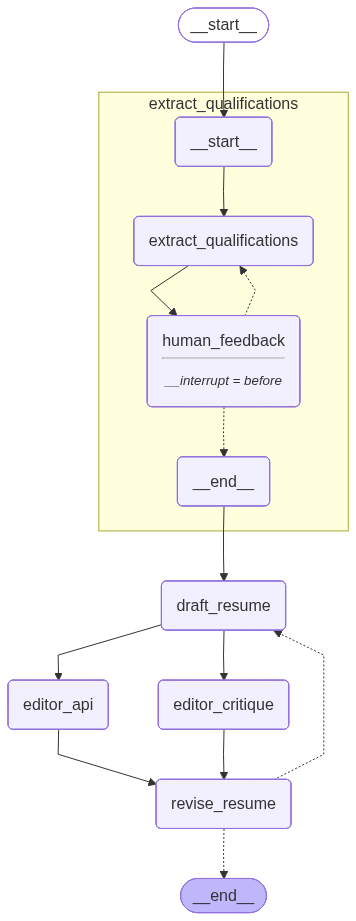

In [84]:
import operator
from typing import Annotated, List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from langgraph.graph import START, END, StateGraph
from langgraph.constants import Send
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# --- Outer graph state ---
class ResumeState(TypedDict):
    job_post: str
    human_feedback: str
    resume_input: str
    qualifications: Qualifications
    resume_draft: str
    editor_feedback: Annotated[List[str], operator.add]  # accumulate feedback
    iteration: int

# --- Step 2: Draft resume ---
def draft_resume(state: ResumeState):
    job_post = state["job_post"]
    qualifications = state["qualifications"]
    resume_input = state["resume_input"]
    feedback = "\n".join(state.get("editor_feedback", []))

    system_message = f"""You are a career coach.
    Tailor the candidate's resume to this job post:

    Job Post:
    {job_post}

    Required Qualifications:
    {qualifications.required}

    Preferred Qualifications:
    {qualifications.preferred}

    Existing Resume:
    {resume_input}

    Previous Draft (if any):
    {state.get("resume_draft", "")}

    Feedback from reviewers:
    {feedback}

    Draft a revised resume highlighting relevant achievements, quantifying impact where possible.
    """
    draft = llm.invoke([SystemMessage(content=system_message)])
    return {"resume_draft": draft.content, "editor_feedback": []}  # clear feedback after applying

# --- Step 3a: Editor 1 (API stub) ---
def editor_api(state: ResumeState):
    return {"editor_feedback": ["[API editor returned no feedback]"]}

# --- Step 3b: Editor 2 (LLM critique) ---
def editor_critique(state: ResumeState):
    draft = state["resume_draft"]
    system_message = """You are a strict resume reviewer.
    Critique the resume draft for:
    - Grammar issues
    - Lack of quantified metrics
    - Weak descriptions of achievements
    Provide actionable suggestions.
    """
    feedback = llm.invoke([SystemMessage(content=system_message), HumanMessage(content=draft)])
    return {"editor_feedback": [feedback.content]}

# --- Step 4: Revise resume ---
def revise_resume(state: ResumeState):
    # increment iteration and let feedback flow back to draft_resume
    return {
        "iteration": state.get("iteration", 0) + 1
    }

# --- Step 5: Route based on iteration count ---
def should_continue(state: ResumeState):
    if state.get("iteration", 0) >= 2:
        return END
    return "draft_resume"

# --- Build main graph ---
builder = StateGraph(ResumeState)

builder.add_node("extract_qualifications", qua_builder.compile(interrupt_before=["human_feedback"]))
builder.add_node("draft_resume", draft_resume)
builder.add_node("editor_api", editor_api)
builder.add_node("editor_critique", editor_critique)
builder.add_node("revise_resume", revise_resume)

builder.add_edge(START, "extract_qualifications")
builder.add_edge("extract_qualifications", "draft_resume")
builder.add_edge("draft_resume", "editor_api")
builder.add_edge("draft_resume", "editor_critique")
builder.add_edge("editor_api", "revise_resume")
builder.add_edge("editor_critique", "revise_resume")
builder.add_conditional_edges("revise_resume", should_continue, ["draft_resume", END])

# Compile
memory = MemorySaver()
resume_graph = builder.compile(checkpointer=memory)

# Optional: visualize
from IPython.display import Image, display
display(Image(resume_graph.get_graph(xray=1).draw_mermaid_png()))


## Conclusion  

Due to the need for supporting **user interaction** during feedback and approval loops,  
the final stage of the workflow has been migrated to **LangGraph Studio**.  
This environment provides a more seamless way to handle iterative edits and human-in-the-loop validation.

Tutorial on how to setup LangGraph Studio can be found at [Tutorial](https://langchain-ai.github.io/langgraph/tutorials/langgraph-platform/local-server/?_gl=1*16rgfli*_gcl_au*OTUwNDIyOTE2LjE3NTczNDU4MDU.*_ga*MjAzMzMxNDcwNi4xNzU3NDY2NjQ0*_ga_47WX3HKKY2*czE3NTc0NjY2NDQkbzEkZzEkdDE3NTc0NjY2NzAkajM0JGwwJGgw).

After the setup is done, just run `langgraph dev` in the `./studio` directory.

The complete interaction of the agentic workflow is documented across five publicly available  
**prompt traces** hosted on **LangSmith**:  

1. [qualification_workflow](https://smith.langchain.com/public/c6cf4040-a6ab-48ba-8eee-1f124323abb9/r) 
2. [qualification_workflow_rewrite_human_feedback](https://smith.langchain.com/public/00bd9b6f-6dc8-446b-979d-b75295298f9c/r)  
3. [resume_workflow](https://smith.langchain.com/public/1bc8a2bb-a1b8-4bf6-8e60-a7ce211e02eb/r)  
